## Introduction
This notebook demonstrates the end-to-end training pipeline for semantic segmentation of satellite imagery. It is organized to take you from dataset preparation to model training, evaluation, and visualization of predictions. The primary goals are:

- Load and preprocess large satellite images by extracting labeled patches.
- Train a U-Net style segmentation model with a ResNet-50 encoder backbone.
- Monitor and evaluate performance using segmentation metrics and qualitative visualizations.
- Save and export trained weights for downstream inference.

### Imports

In [1]:
%matplotlib inline

import timm
from torchgeo.models import ResNet50_Weights, resnet50

from pathlib import Path
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Code written with ChatGPT-5
def find_repo_root(start: Path = Path.cwd(), markers=("pyproject.toml", "setup.py", ".git", "README.md")) -> Path:
    """_summary_
    Set the folder to the current path for correct folder alignment. 
    """
    p = start.resolve()
    while True:
        if any((p / m).exists() for m in markers):
            return p
        if p.parent == p: 
            return start.resolve()
        p = p.parent

repo_root = find_repo_root()
sys.path.insert(0, str(repo_root))

print("repo_root:", repo_root)

repo_root: C:\Users\nikoo\IN5310\satelite_images


### MODEL
We use a resnet50 as a backbone model. The model specifically has been pretrained on RGB Sentinel2 images using the self-supervised learning method MOCO. 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rgb_weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
model = resnet50(rgb_weights)

In [4]:
# optimizer only for trainable params (head + any unfrozen)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

## UNET
To create the segmentation head we use a simple UNET architecture. ESA worldcover contains 11 classes so we set the number of classes to 11 (https://blog.vito.be/remotesensing/release-of-the-10-m-worldcover-map). 

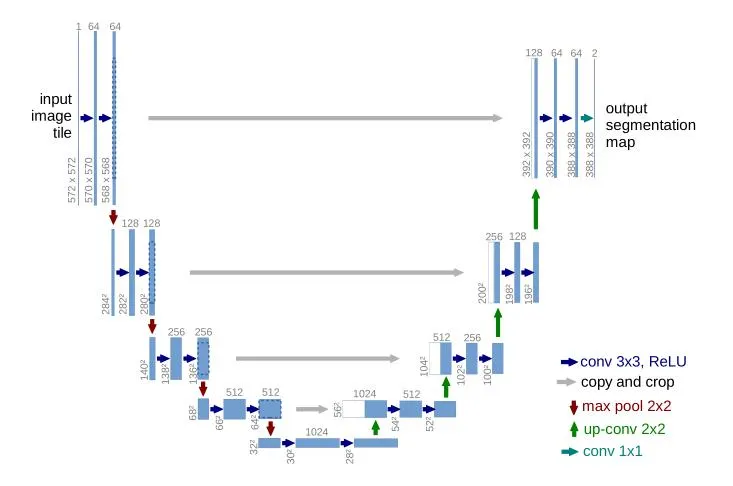

In [5]:
# See code in res50_unet.py
from src.model.res50_unet import build_unet_from_resnet50
unet = build_unet_from_resnet50(model, num_classes = 11)
unet.to(device)

ResNet50UNet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

### Load image-mask pairs

In [6]:
# See code in load_masks.py
from src.model.load_masks import load_satelite_masks
loader = load_satelite_masks("nikolkoo/SatelliteSegmentation", wrap_dataloader = True)

#### Run training

In [ ]:
# See code in run_segmentation.py
from src.model.run_segmentation import run_training

save_path = "model"
run_training(unet, loader, epochs = 50, device = device, save_path = save_path)

### Visualize segmentation

#### Data
Load images and mask pairs. These are used as the ground truth.

In [ ]:
ds = load_satelite_masks("nikolkoo/SatelliteSegmentation", wrap_dataloader = False)
img = ds["image"][10]
mask = ds["mask"][10]

#### Visualization function
The function below forwards the image through the neural network and returns the segmentation map with the ground truth image and mask. This can be used for further empirical or quantitative analysis of the model. 

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

def visualize_segmentation(model, img, mask, device=None, class_colors=None, alpha=0.5):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # prepare numpy image
    if isinstance(img, Image.Image):
        arr = np.array(img)
    elif isinstance(img, torch.Tensor):
        arr = img.detach().cpu().numpy()
        arr = np.transpose(arr, (1,2,0))
        mask = np.transpose(mask, (1,2,0))
    else:
        arr = np.array(img)
    if arr.ndim == 2:  # single channel -> convert to 3-channel gray
        arr = np.stack([arr]*3, axis=-1)
    h, w, c = arr.shape
    assert c >= 3, "expected 3-channel image"

    # normalize to [0,1] float32
    if arr.dtype == np.uint8:
        img_f = arr.astype(np.float32) / 255.0
    else:
        img_f = arr.astype(np.float32)
        if img_f.max() > 1.0:
            img_f = img_f / 255.0

    # tensor shape (1, C, H, W)
    inp = torch.from_numpy(img_f[..., :3]).permute(2,0,1).unsqueeze(0).float().to(device)

    model.eval()
    with torch.no_grad():
        logits = model(inp)                      # (1, num_cls, H, W) expected
        pred = logits.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.int32)  # (H, W)

    # default colormap for up to 11 classes
    if class_colors is None:
        default_colors = np.array([
                [  0,   0,   0],  # 0  No data
                [  0, 100,   0],  # 1  0x006400  Tree cover (10)
                [255, 187,  34],  # 2  0xffbb22  Shrubland (20)
                [255, 255,  76],  # 3  0xffff4c  Grassland (30)
                [240, 150, 255],  # 4  0xf096ff  Cropland (40)
                [250,   0,   0],  # 5  0xfa0000  Built up (50)
                [180, 180, 180],  # 6  0xb4b4b4  Bare / sparse veg (60)
                [240, 240, 240],  # 7  0xf0f0f0  Snow and Ice (70)
                [  0, 100, 200],  # 8  0x0064c8  Permanent water bodies (80)
                [  0, 150, 160],  # 9  0x0096a0  Herbaceous wetland (90)
                [250, 230, 160],  #10  0xfae6a0  Moss and lichen (100)
            ], dtype=np.uint8)
        class_colors = default_colors

    # ensure class_colors covers all predicted classes
    maxc = pred.max()
    if maxc >= len(class_colors):
        # extend by repeating a colormap
        rng = np.random.RandomState(0)
        extra = rng.randint(0, 255, size=(maxc - len(class_colors) + 1, 3), dtype=np.uint8)
        class_colors = np.vstack([class_colors, extra])

    color_mask = class_colors[pred]  # (H, W, 3) uint8
    truth_mask = class_colors[mask.squeeze(-1).cpu().numpy().astype(np.int32)]

    # plot original + overlay
    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(img_f if img_f.max() <= 1.0 else img_f/255.0)
    ax.imshow(color_mask, alpha=alpha)
    ax.axis("off")
    plt.show()

    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(img_f if img_f.max() <= 1.0 else img_f/255.0)
    ax.imshow(truth_mask, alpha=alpha)
    ax.axis("off")
    plt.show()

    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(img_f if img_f.max() <= 1.0 else img_f/255.0)
    ax.axis("off")
    plt.show()

    return pred
#visualize_segmentation(unet, img, mask)

#### Main function
In the main function we load the model and all the 'visualize_segmentation' function. The function takes care of setting the model to eval(). 

In [ ]:
import torch
from pathlib import Path

rgb_weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
encoder = resnet50(rgb_weights)
unet = build_unet_from_resnet50(encoder, num_classes=11)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet.to(device)

epochs = [1, 50]
for epoch in epochs:
    ckpt_path = Path("model") / f"checkpoint_epoch_{epoch}.pt"  # adjust filename
    ckpt = torch.load(ckpt_path, map_location=device)

    # handle possible DataParallel 'module.' prefix
    state = ckpt["model_state"]
    if any(k.startswith("module.") for k in state):
        state = {k.replace("module.", ""): v for k, v in state.items()}

    unet.load_state_dict(state)
    visualize_segmentation(unet, img, mask, alpha = 1)